# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [41]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: E:\vscode\workspace\main-newest\mlfs-book
HopsworksSettings initialized!


In [42]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [43]:
today = datetime.datetime.now() - datetime.timedelta(0)
# today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 18, 16, 52, 416411)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [44]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 18:16:52,482 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 18:16:52,498 INFO: Initializing external client
2025-11-18 18:16:52,500 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 18:16:53,102 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 18:16:54,006 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286333


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [45]:
mr = project.get_model_registry()

# retrieved_model = mr.get_model(
#     name="air_quality_xgboost_model",
#     version=1,
# )

# fv = retrieved_model.get_feature_view()

# # Download the saved model artifacts to a local directory
# saved_model_dir = retrieved_model.download()

In [46]:
mr = project.get_model_registry()

retrieved_model_new = mr.get_model(
    name="air_quality_xgboost_model_new",
    version=1,
)

fv_new = retrieved_model_new.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_new = retrieved_model_new.download()

2025-11-18 18:16:59,887 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/509377 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108134 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21941 elapsed<00:00 remaining<?

In [47]:
# # Loading the XGBoost regressor model and label encoder from the saved model directory
# # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
# retrieved_xgboost_model = XGBRegressor()

# retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# # Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [48]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_new = XGBRegressor()

retrieved_xgboost_model_new.load_model(saved_model_dir_new + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_new

XGBRegressor(base_score='8.400252E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [49]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,7.05,0.0,7.145796,319.085693,Shanghai
1,2025-11-21 00:00:00+00:00,10.70,0.0,6.849467,356.987274,Shanghai
2,2025-11-20 00:00:00+00:00,8.15,0.0,1.297998,213.690094,Shanghai
3,2025-11-22 00:00:00+00:00,11.40,0.0,6.369050,132.709366,Shanghai
4,2025-11-23 00:00:00+00:00,15.55,0.0,3.758510,286.699310,Shanghai
5,2025-11-24 00:00:00+00:00,10.75,0.0,15.021105,314.029053,Shanghai


In [50]:
import numpy as np
# Ensure the 'date' column is in datetime format
batch_data_new = batch_data.copy()
batch_data_new['date'] = pd.to_datetime(batch_data_new['date'])

df_future = batch_data_new[batch_data_new['date'].dt.date > today.date()].copy()

print(f"Predicting for {len(df_future)} days...")

# [IMPORTANT] Define the exact feature columns used during model training.
# The order MUST match the order used in 'model.fit()'.
# Please adjust this list if your training order was different.
train_features = [
    'temperature_2m_mean',          # Weather feature
    'precipitation_sum',            # Weather feature
    'wind_speed_10m_max',           # Weather feature
    'wind_direction_10m_dominant',   # Weather feature
    'pm25_lag_3_mean',               # The new feature
]

aq_fg = fs.get_feature_group(name='air_quality', version=1)
start_lookback = (today - datetime.timedelta(days=7)).strftime('%Y-%m-%d')
df_history = aq_fg.filter(aq_fg.date >= start_lookback).read()

df_history['date'] = pd.to_datetime(df_history['date']).dt.tz_localize(None)
df_history = df_history[df_history['date'] <= today].sort_values('date')

recent_pm25_values = df_history['pm25'].tail(3).tolist()
# Make sure this variable exists before running the loop.

# ==========================================
# 2. Recursive Prediction Loop
# ==========================================

print("Starting recursive forecasting...")

# Iterate through each row of the future weather data
for index, row in df_future.iterrows():
    
    # --- Step A: Calculate the lag feature dynamically ---
    # We take the average of the last 3 values in our history list.
    # As the loop progresses, this list will include the predictions we just made.
    current_lag_mean = np.mean(recent_pm25_values[-3:])
    
    # --- Step B: Prepare the input row for the model ---
    # Create a single-row DataFrame with the weather data + the calculated lag feature
    input_row = pd.DataFrame({
        'temperature_2m_mean': [row['temperature_2m_mean']],
        'precipitation_sum': [row['precipitation_sum']],
        'wind_speed_10m_max': [row['wind_speed_10m_max']],
        'wind_direction_10m_dominant': [row['wind_direction_10m_dominant']],
        'pm25_lag_3_mean': [current_lag_mean]  
    })
    
    # Reorder columns to ensure they match the training schema
    input_row = input_row[train_features]
    
    # --- Step C: Make the prediction ---
    # Use the loaded XGBoost model to predict PM2.5 for this specific day
    pred_pm25 = retrieved_xgboost_model_new.predict(input_row)[0]
    
    # --- Step D: Update the history pool ---
    # Append the predicted value to the list.
    # This is crucial: it allows the NEXT day's prediction to use THIS prediction 
    # as part of its "past 3 days average".
    recent_pm25_values.append(pred_pm25)
    
    # --- Step E: Store the result ---
    # We save the prediction back into the dataframe
    # (Using the original index from batch_data to ensure it maps correctly)
    batch_data_new.loc[index, 'predicted_pm25'] = pred_pm25

# ==========================================
# 3. Result
# ==========================================
print("Prediction complete. Here is the updated batch_data:")
# filtering to show only the future days with predictions
print(batch_data_new[batch_data_new['date'].dt.date > today.date()][['date', 'predicted_pm25']])

Predicting for 6 days...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 
Starting recursive forecasting...
Prediction complete. Here is the updated batch_data:
                       date  predicted_pm25
0 2025-11-19 00:00:00+00:00       94.600990
1 2025-11-21 00:00:00+00:00      105.516289
2 2025-11-20 00:00:00+00:00      120.172180
3 2025-11-22 00:00:00+00:00       71.784203
4 2025-11-23 00:00:00+00:00      124.624641
5 2025-11-24 00:00:00+00:00      126.737022


In [51]:
batch_data_new

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-19 00:00:00+00:00,7.05,0.0,7.145796,319.085693,Shanghai,94.600990
1,2025-11-21 00:00:00+00:00,10.70,0.0,6.849467,356.987274,Shanghai,105.516289
2,2025-11-20 00:00:00+00:00,8.15,0.0,1.297998,213.690094,Shanghai,120.172180
3,2025-11-22 00:00:00+00:00,11.40,0.0,6.369050,132.709366,Shanghai,71.784203
4,2025-11-23 00:00:00+00:00,15.55,0.0,3.758510,286.699310,Shanghai,124.624641
5,2025-11-24 00:00:00+00:00,10.75,0.0,15.021105,314.029053,Shanghai,126.737022


In [52]:
batch_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [53]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [54]:
# batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [55]:
# batch_data['street'] = street
# batch_data['city'] = city
# batch_data['country'] = country
# # Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
# batch_data = batch_data.sort_values(by=['date'])
# batch_data

In [56]:
batch_data_new['street'] = street
batch_data_new['city'] = city
batch_data_new['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data_new['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data_new = batch_data_new.sort_values(by=['date'])
batch_data_new

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,7.05,0.0,7.145796,319.085693,Shanghai,94.600990,Jiading Nanxiang,China,1
2,2025-11-20 00:00:00+00:00,8.15,0.0,1.297998,213.690094,Shanghai,120.172180,Jiading Nanxiang,China,3
1,2025-11-21 00:00:00+00:00,10.70,0.0,6.849467,356.987274,Shanghai,105.516289,Jiading Nanxiang,China,2
3,2025-11-22 00:00:00+00:00,11.40,0.0,6.369050,132.709366,Shanghai,71.784203,Jiading Nanxiang,China,4
4,2025-11-23 00:00:00+00:00,15.55,0.0,3.758510,286.699310,Shanghai,124.624641,Jiading Nanxiang,China,5
5,2025-11-24 00:00:00+00:00,10.75,0.0,15.021105,314.029053,Shanghai,126.737022,Jiading Nanxiang,China,6


In [57]:
# batch_data.info()

In [58]:
batch_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [59]:

# pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
# plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

# plt.show()

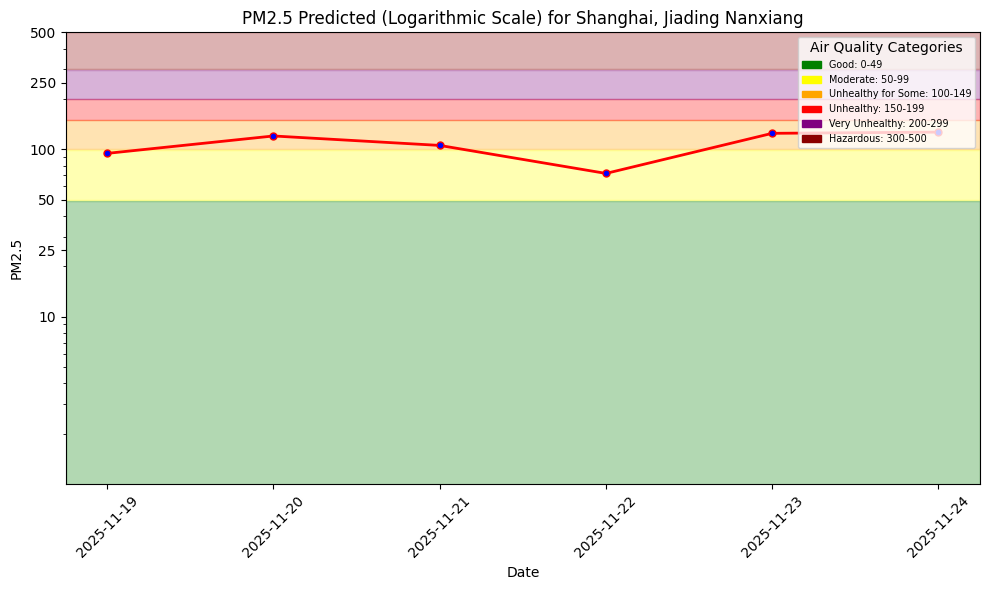

In [60]:
pred_file_path_new = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_new.png"
plt_new = util.plot_air_quality_forecast(city, street, batch_data_new, pred_file_path_new)

plt_new.show()

In [61]:
# # Get or create feature group
# monitor_fg = fs.get_or_create_feature_group(
#     name='aq_predictions',
#     description='Air Quality prediction monitoring',
#     version=1,
#     primary_key=['city','street','date','days_before_forecast_day'],
#     event_time="date"
# )

In [62]:
# Get or create feature group
monitor_fg_new = fs.get_or_create_feature_group(
    name='aq_predictions_new',
    description='Air Quality prediction monitoring with new features',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [63]:
# monitor_fg.insert(batch_data, wait=True)

In [64]:
monitor_fg_new.insert(batch_data_new, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286333/fs/1273958/fg/1719005


Uploading Dataframe: 100.00% |███████████████████████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286333/jobs/named/aq_predictions_new_1_offline_fg_materialization/executions
2025-11-18 18:17:27,292 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 18:17:30,499 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:19:31,228 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 18:19:37,587 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-18 18:19:37,995 INFO: Waiting for log aggregation to finish.
2025-11-18 18:19:37,997 INFO: Execution finished successfully.


(Job('aq_predictions_new_1_offline_fg_materialization', 'SPARK'), None)

In [65]:
# # We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
# monitoring_df

In [66]:
monitoring_df_new = monitor_fg_new.filter(monitor_fg_new.days_before_forecast_day == 1).read()
monitoring_df_new

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,7.05,0.0,7.145796,319.085693,Shanghai,94.60099,Jiading Nanxiang,China,1


In [67]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,date,pm25,country,city,street,url
0,2021-07-06 00:00:00+00:00,47.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
1,2020-12-14 00:00:00+00:00,62.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
2,2020-09-20 00:00:00+00:00,102.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
3,2019-12-24 00:00:00+00:00,88.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
4,2023-12-16 00:00:00+00:00,94.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
...,...,...,...,...,...,...
2579,2019-01-29 00:00:00+00:00,117.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
2580,2019-01-17 00:00:00+00:00,163.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
2581,2025-11-16 00:00:00+00:00,55.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208
2582,2025-11-17 00:00:00+00:00,61.0,China,Shanghai,Jiading Nanxiang,https://api.waqi.info/feed/@10208


In [68]:
# outcome_df = air_quality_df[['date', 'pm25']]
# preds_df =  monitoring_df[['date', 'predicted_pm25']]

# hindcast_df = pd.merge(preds_df, outcome_df, on="date")
# hindcast_df = hindcast_df.sort_values(by=['date'])

# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
# hindcast_df

In [69]:
air_quality_3mean_and_weather_fg = fs.get_feature_group(
    name='air_quality_3mean_and_weather',
    version=1,
)
air_quality_3mean_and_weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.84s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_3_mean
0,2021-08-17 00:00:00+00:00,25.302832,1.700000,18.356470,24.011616,Shanghai,39.666667
1,2018-10-03 00:00:00+00:00,20.952833,0.000000,19.093580,35.825344,Shanghai,84.333333
2,2025-04-25 00:00:00+00:00,15.529919,0.000000,10.985900,90.995239,Shanghai,128.333333
3,2025-01-27 00:00:00+00:00,2.004917,0.000000,16.824945,301.150024,Shanghai,72.000000
4,2023-05-26 00:00:00+00:00,24.017416,18.900000,21.995380,146.861710,Shanghai,91.333333
...,...,...,...,...,...,...,...
2581,2025-04-01 00:00:00+00:00,9.948667,0.000000,8.827344,110.407486,Shanghai,73.333333
2582,2023-03-19 00:00:00+00:00,9.796584,0.100000,15.683776,107.979111,Shanghai,42.666667
2583,2023-08-10 00:00:00+00:00,28.959085,0.300000,18.584511,323.566254,Shanghai,52.666667
2584,2023-03-17 00:00:00+00:00,7.782000,15.000001,20.883104,2.010485,Shanghai,45.333333


In [70]:
def backfill_predictions_for_monitoring_new(features_fg, air_quality_df, monitor_fg, model):
    """
    Args:
        features_fg: The Fused Feature Group (air_quality_3mean_and_weather_fg)
        air_quality_df: DataFrame containing actual PM2.5 values (for comparison)
        monitor_fg: The Monitor Feature Group
        model: The trained XGBoost model
    """
    
    # 1. Read historical features (Weather + Mean PM2.5)
    features_df = features_fg.read()
    
    # 2. Sort and select the last 10 days
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    
    # 3. Predict
    features_df['predicted_pm25'] = model.predict(features_df[[
        'temperature_2m_mean', 
        'precipitation_sum', 
        'wind_speed_10m_max', 
        'wind_direction_10m_dominant',
        'pm25_lag_3_mean'
    ]])
    
    # # 4. Merge with actuals (Standardize dates to prevent timezone errors)
    features_df['date'] = pd.to_datetime(features_df['date']).dt.tz_localize(None)
    air_quality_df['date'] = pd.to_datetime(air_quality_df['date']).dt.tz_localize(None)

    # Merge predictions with actuals ('pm25')
    df = pd.merge(features_df, air_quality_df[['date', 'pm25', 'street', 'country']], on=["date"])
    
    # 5. Upload to Monitor FG
    df['days_before_forecast_day'] = 1
    hindcast_df = df

    columns_to_upload = [
        'date', 
        'temperature_2m_mean',
        'precipitation_sum',
        'wind_speed_10m_max',
        'wind_direction_10m_dominant',
        'city', 
        'predicted_pm25', 
        'days_before_forecast_day', 
        'street', 
        'country'
    ]
    # Drop actuals before inserting (Monitor FG usually only stores predictions)
    # df = df.drop('pm25', axis=1)
    df = df[columns_to_upload]
    
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    
    return hindcast_df


    
outcome_df = air_quality_df[['date', 'pm25']]
preds_df_new =  monitoring_df_new[['date', 'predicted_pm25']]

outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)
preds_df_new['date'] = pd.to_datetime(preds_df_new['date']).dt.tz_localize(None)

hindcast_df_new = pd.merge(preds_df_new, outcome_df, on="date")
hindcast_df_new = hindcast_df_new.sort_values(by=['date'])

print(hindcast_df_new)
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_new) == 0:
    hindcast_df_new = backfill_predictions_for_monitoring_new(air_quality_3mean_and_weather_fg, air_quality_df, monitor_fg_new, retrieved_xgboost_model_new)
# hindcast_df_new

2025-11-18 18:19:43,820 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 18:19:43,823 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Empty DataFrame
Columns: [date, predicted_pm25, pm25]
Index: []
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


Uploading Dataframe: 100.00% |█████████████████████████████████████████████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286333/jobs/named/aq_predictions_new_1_offline_fg_materialization/executions
2025-11-18 18:20:16,461 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 18:20:19,689 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 18:21:55,376 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 18:21:55,518 INFO: Waiting for log aggregation to finish.
2025-11-18 18:22:04,202 INFO: Execution finished successfully.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [71]:
# try:
#     monitor_fg_new.delete()
#     print("🗑️ 已删除旧的 Monitor FG，数据已清空。")
# except:
#     pass

In [72]:
# hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
# plt.show()

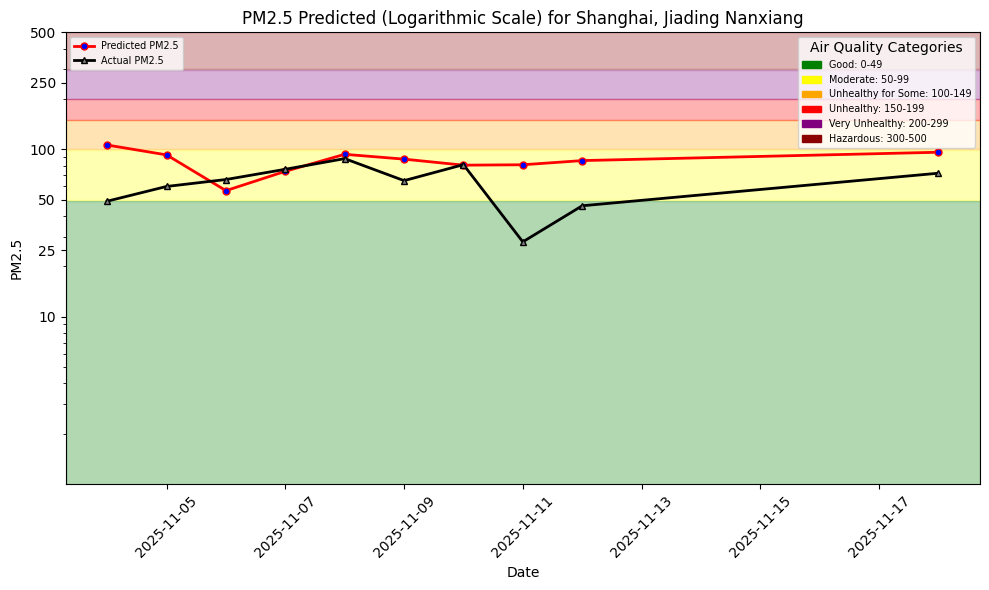

In [73]:
hindcast_file_path_new = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_new.png"
plt_new = util.plot_air_quality_forecast(city, street, hindcast_df_new, hindcast_file_path_new, hindcast=True)
plt_new.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [75]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality_new") == False:
    dataset_api.mkdir("Resources/airquality_new")
dataset_api.upload(pred_file_path_new, f"Resources/airquality_new/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path_new, f"Resources/airquality_new/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_new")

Uploading E:\vscode\workspace\main-newest\mlfs-book/docs/air-quality/assets/img/pm25_forecast_new.png: 0.000%|…

Uploading E:\vscode\workspace\main-newest\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_new.png: 0.…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286333/settings/fb/path/Resources/airquality_new


---